# Prática: Classificação com Redes Neurais em PyTorch

## Introdução

Este notebook é um exercício prático para a construção, treinamento e avaliação de uma rede neural para um problema de classificação. As células de texto (Markdown) fornecerão o embasamento teórico, e sua tarefa será implementar a lógica correspondente nas células de código subsequentes.

O objetivo é solidificar o entendimento sobre o pipeline de um projeto em PyTorch, desde a manipulação de dados até a avaliação do modelo.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

## 1. Geração e Visualização do Dataset

Para que a aplicação de uma rede neural seja justificada, o problema de classificação não deve ser linearmente separável. Utilizaremos o `numpy` para gerar tal dataset.

Para fins de visualização e para aumentar a dimensionalidade, uma terceira feature será artificialmente criada como uma combinação não-linear das duas features originais. Por fim, os dados serão normalizados, o que é uma prática recomendada que auxilia na estabilidade e velocidade do treinamento de redes neurais.

In [2]:
# Geração e preparação do dataset
from sklearn.preprocessing import StandardScaler

def generate_spiral_data(n_samples_per_class=1000, n_turns=3, noise=0.3):
    """
    Gera um dataset de duas espirais 3D entrelaçadas.
    """
    # Geração dos pontos da primeira espiral (Classe 0)
    t = np.linspace(0, n_turns * 2 * np.pi, n_samples_per_class)
    x1 = t * np.cos(t)
    y1 = t * np.sin(t)
    z1 = t

    # Adição de ruído gaussiano
    X1 = np.vstack((x1, y1, z1)).T
    X1 += noise * np.random.randn(*X1.shape)
    y1 = np.zeros(n_samples_per_class)

    # Geração dos pontos da segunda espiral (Classe 1), defasada em 180 graus
    x2 = t * np.cos(t + np.pi)
    y2 = t * np.sin(t + np.pi)
    z2 = t

    # Adição de ruído gaussiano
    X2 = np.vstack((x2, y2, z2)).T
    X2 += noise * np.random.randn(*X2.shape)
    y2 = np.ones(n_samples_per_class)

    # Combinação e embaralhamento dos dados
    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2))

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    y = y[indices]

    return X, y

# Geração dos dados
X, y = generate_spiral_data()

# Normalização dos dados, uma prática padrão
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (labels): {y.shape}")

Shape de X (features): (2000, 3)
Shape de y (labels): (2000,)


### Visualização 3D dos Dados

A visualização do dataset em um espaço tridimensional nos permite obter uma intuição sobre a complexidade da fronteira de decisão que o modelo precisará aprender para separar as classes.

In [3]:
fig = px.scatter_3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    color=y,
    color_continuous_scale=px.colors.qualitative.Vivid,
    title="Dataset Sintético 3D para Classificação"
)
fig.update_traces(marker=dict(size=3))
fig.show()

## 2. Preparação dos Dados para o PyTorch

Nesta seção, você irá encapsular os dados NumPy em classes `Dataset` e `DataLoader` do PyTorch, que são abstrações fundamentais para o carregamento e a iteração sobre os dados de forma eficiente durante o treinamento.

### 2.1. A Classe `Dataset`
É necessário criar uma classe que herde de `torch.utils.data.Dataset`. Esta classe customizada deve implementar três métodos:
- `__init__(self, features, labels)`: O construtor, onde os dados são recebidos. É aqui que os arrays NumPy devem ser convertidos para tensores do PyTorch. As features (X) devem ser do tipo `torch.float32` e os rótulos (y) do tipo `torch.long`.
- `__len__(self)`: Método que retorna o número total de amostras no dataset.
- `__getitem__(self, idx)`: Método que permite o acesso a uma amostra específica do dataset através de um índice `idx`. Ele deve retornar um par `(feature, label)`.

In [4]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        # Converte arrays NumPy para tensores PyTorch
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        # Retorna o número total de amostras
        return len(self.features)

    def __getitem__(self, idx):
        # Retorna um par (feature, label) para um dado índice
        return self.features[idx], self.labels[idx]

### 2.2. Divisão dos Dados e `DataLoader`
Com a classe `Dataset` definida, o próximo passo é:
1.  Dividir os arrays `X` e `y` em conjuntos de treinamento e teste utilizando `train_test_split`.
2.  Instanciar a sua classe Dataset para cada um desses conjuntos.
3.  Criar instâncias de `DataLoader` para os dois datasets. O `DataLoader` é um iterador que agrupa os dados em mini-lotes (`mini-batches`), com a opção de embaralhá-los a cada época, uma prática essencial para o conjunto de treino.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [6]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 3. Arquitetura da Rede Neural

A arquitetura do modelo será composta por camadas ocultas e uma camada de saída.
- As camadas ocultas são responsáveis por aprender representações complexas dos dados e podem ser construídas com `nn.Linear` e `nn.ReLU`.
- A **camada de saída** deve ter **apenas 1 neurônio**.
- Após a última camada linear, deve ser aplicada uma função de ativação `nn.Sigmoid()`.

A saída do modelo será um único valor entre 0 e 1 para cada amostra de entrada, que pode ser interpretado como a probabilidade da amostra pertencer à classe 1.
$$ \hat{y} = \sigma(W_{\text{out}} \cdot a_{\text{hidden}} + b_{\text{out}}) $$
Onde $a_{\text{hidden}}$ é a ativação da última camada oculta e $\sigma$ é a função Sigmoid.

In [7]:
import torch
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=3, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1)
        )

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

model = MLPClassifier()
print(model)

MLPClassifier(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


## 4. Função de Custo e Otimizador

A **função de custo** para este problema será a `nn.BCELoss` (*Binary Cross-Entropy Loss*). Esta função mede o erro entre a probabilidade prevista pelo modelo e o rótulo verdadeiro (0 ou 1), sendo a escolha canônica para classificação binária.

Para o **otimizador**, utilizaremos o `torch.optim.SGD`, que implementa o algoritmo de descida do gradiente estocástico. Sua principal configuração é a **taxa de aprendizado** (`learning_rate`).

In [8]:
import torch.optim as optim
import torch.nn as nn

learning_rate = 0.01
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## 5. Loop de Treinamento

O loop de treinamento segue uma estrutura de 5 passos, iterando sobre os dados por um número definido de épocas. Para cada lote de dados, o ciclo é:

1.  **Forward Pass**: Propagar os dados de entrada pelo modelo para obter as predições.
2.  **Cálculo da Perda**: Calcular a perda comparando as predições com os rótulos verdadeiros.
3.  **Zerar Gradientes**: Limpar os gradientes da iteração anterior (`optimizer.zero_grad()`).
4.  **Backward Pass (Backpropagation)**: Calcular os gradientes da perda em relação a cada parâmetro (`loss.backward()`).
5.  **Atualização dos Pesos**: Atualizar os pesos do modelo usando o otimizador (`optimizer.step()`).

In [9]:
import torch
import numpy as np

num_epochs = 500
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # Coloca o modelo em modo de treinamento
    model.train()
    for X_batch, y_batch in train_loader:
        # 1. Forward Pass
        outputs = model(X_batch)

        # 2. Cálculo da Perda
        loss = loss_fn(outputs, y_batch.float().unsqueeze(1))

        # 3. Zerar os Gradientes
        optimizer.zero_grad()

        # 4. Backward Pass
        loss.backward()

        # 5. Atualização dos Pesos
        optimizer.step()

    # Avaliação da acurácia de treinamento ao final da época
    # Coloca o modelo em modo de avaliação (desativa o dropout, etc.)
    model.eval()
    with torch.no_grad(): # Desativa o cálculo de gradientes
        total_correct = 0
        total_samples = 0
        for X_batch_val, y_batch_val in train_loader:
            outputs_val = model(X_batch_val)
            predicted = (outputs_val > 0.5).float()
            total_correct += (predicted.squeeze() == y_batch_val).sum().item()
            total_samples += y_batch_val.size(0)

        accuracy = total_correct / total_samples
        train_accuracies.append(accuracy)
        train_losses.append(loss.item())

    # Imprime o progresso a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/500], Loss: 0.6817, Accuracy: 0.5288
Epoch [20/500], Loss: 0.7111, Accuracy: 0.5475
Epoch [30/500], Loss: 0.6346, Accuracy: 0.5487
Epoch [40/500], Loss: 0.7247, Accuracy: 0.5506
Epoch [50/500], Loss: 0.6264, Accuracy: 0.5531
Epoch [60/500], Loss: 0.6887, Accuracy: 0.5713
Epoch [70/500], Loss: 0.6676, Accuracy: 0.5744
Epoch [80/500], Loss: 0.6627, Accuracy: 0.5900
Epoch [90/500], Loss: 0.6714, Accuracy: 0.6312
Epoch [100/500], Loss: 0.6608, Accuracy: 0.6481
Epoch [110/500], Loss: 0.6657, Accuracy: 0.6587
Epoch [120/500], Loss: 0.6952, Accuracy: 0.6887
Epoch [130/500], Loss: 0.6274, Accuracy: 0.7031
Epoch [140/500], Loss: 0.6245, Accuracy: 0.6731
Epoch [150/500], Loss: 0.6705, Accuracy: 0.6550
Epoch [160/500], Loss: 0.6467, Accuracy: 0.6425
Epoch [170/500], Loss: 0.6855, Accuracy: 0.6300
Epoch [180/500], Loss: 0.7134, Accuracy: 0.6325
Epoch [190/500], Loss: 0.6188, Accuracy: 0.6569
Epoch [200/500], Loss: 0.6596, Accuracy: 0.6725
Epoch [210/500], Loss: 0.6338, Accuracy: 0.6813
E

## 6. Visualização e Avaliação do Desempenho

### Curvas de Aprendizagem
Após o treinamento, é fundamental analisar as curvas de aprendizagem. A plotagem da perda e da acurácia ao longo das épocas nos permite diagnosticar se o modelo aprendeu corretamente e se há sinais de problemas como *overfitting* ou *underfitting*.

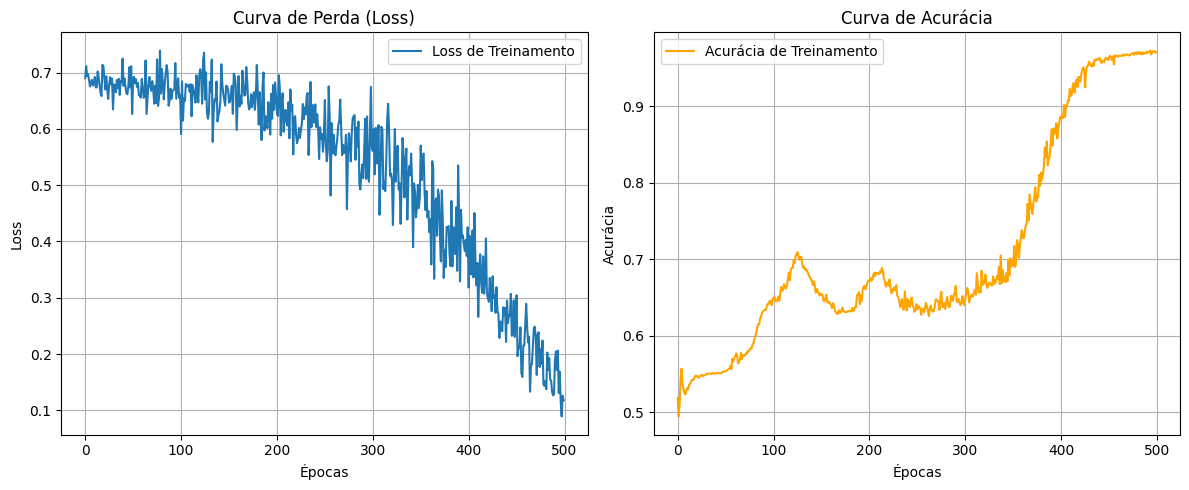

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Gráfico da Perda (Loss)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss de Treinamento')
plt.title('Curva de Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico da Acurácia
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Acurácia de Treinamento', color='orange')
plt.title('Curva de Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Avaliação Final no Conjunto de Teste
A avaliação final deve ser feita no conjunto de teste, que o modelo não viu durante o treinamento. Isso fornece uma estimativa imparcial de sua capacidade de generalização.

Para a fase de avaliação (inferência), é importante colocar o modelo em modo de avaliação com `model.eval()` e realizar os cálculos dentro de um bloco `with torch.no_grad()` para desativar o cálculo de gradientes.

In [13]:
import torch

# Coloca o modelo em modo de avaliação
model.eval()

# Desativa o cálculo de gradientes
with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predicted = (outputs > 0.5).float()

        total_correct += (predicted.squeeze() == y_batch).sum().item()
        total_samples += y_batch.size(0)

    test_accuracy = total_correct / total_samples
    print(f'Acurácia no conjunto de testes: {test_accuracy:.4f}')

Acurácia no conjunto de testes: 0.9800


In [14]:
import plotly.express as px

# Obtemos as predições do modelo para o conjunto de teste
model.eval()
with torch.no_grad():
    test_outputs = model(test_dataset.features)
    test_predicted = (test_outputs > 0.5).float().squeeze().numpy()

fig = px.scatter_3d(
    x=test_dataset.features.numpy()[:, 0],
    y=test_dataset.features.numpy()[:, 1],
    z=test_dataset.features.numpy()[:, 2],
    color=test_predicted,
    color_continuous_scale=px.colors.qualitative.Vivid,
    title="Predições no Conjunto de Testes"
)
fig.update_traces(marker=dict(size=3))
fig.show()